Building Material Authenticators using Prompt Gamma Ray Activation Analysis
===

Author: Nathan A. Mahynski

Date: 2023/09/26

Description: Build classifiers and authenticators for real-world materials using PGAA spectra.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mahynski/pychemauth/blob/main/docs/jupyter/applications/2023_pgaa.ipynb)

This is based on [Mahynski, N.A., Monroe, J.I., Sheen, D.A. et al. Classification and authentication of materials using prompt gamma ray activation analysis. J Radioanal Nucl Chem 332, 3259–3271 (2023). https://doi.org/10.1007/s10967-023-09024-x](https://doi.org/10.1007/s10967-023-09024-x)

~~~code
@article{Mahynski2023,
   author = {Nathan A. Mahynski and Jacob I. Monroe and David A. Sheen and Rick L. Paul and H. Heather Chen-Mayer and Vincent K. Shen},
   doi = {10.1007/s10967-023-09024-x},
   issn = {0236-5731},
   journal = {Journal of Radioanalytical and Nuclear Chemistry},
   month = {7},
   title = {Classification and authentication of materials using prompt gamma ray activation analysis},
   url = {https://link.springer.com/10.1007/s10967-023-09024-x},
   year = {2023},
}
~~~

Also see the associated [GitHub repository](https://github.com/mahynski/pgaa-material-authentication).

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/mahynski/pychemauth@main
    import os
    os.kill(os.getpid(), 9) # Automatically restart the runtime to reload libraries

In [2]:
try:
    import pychemauth
except:
    raise ImportError("pychemauth not installed")

import matplotlib.pyplot as plt
%matplotlib inline

import watermark
%load_ext watermark

%load_ext autoreload
%autoreload 2

In [3]:
import sklearn
import imblearn
import tqdm 

import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

from pychemauth.datasets import load_pgaa
from pychemauth.preprocessing.scaling import CorrectedScaler
from pychemauth.preprocessing.imbalanced import ScaledSMOTEENN
from pychemauth.classifier.simca import SIMCA_Authenticator
from pychemauth.classifier.plsda import PLSDA

In [4]:
%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

Compiler    : GCC 12.2.0
OS          : Linux
Release     : 6.2.0-33-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 40
Architecture: 64bit

watermark : 2.4.3
imblearn  : 0.11.0
pandas    : 1.5.3
numpy     : 1.24.3
json      : 2.0.9
pychemauth: 0.0.0b3
sklearn   : 1.3.0
matplotlib: 3.7.2
tqdm      : 4.66.1
seaborn   : 0.12.2



<h3>Load the Data</h3>

In [5]:
# You will need an active internet connection - this function loads the data directly from the GitHub repo above.
# These spectra have already been preprocessed as described in the paper.
data_bunch = load_pgaa()

In [6]:
data_bunch.keys()

dict_keys(['data', 'target', 'feature_names', 'target_names', 'frame', 'DESCR'])

In [7]:
data_bunch['DESCR']

'Dataset reported in Mahynski, N.A., Monroe, J.I., Sheen, D.A. et al. Classification and authentication of materials using prompt gamma ray activation analysis. J Radioanal Nucl Chem 332, 3259–3271 (2023). https://doi.org/10.1007/s10967-023-09024-x . See this publication for a full description. Briefly, rows of X are PGAA spectra for different materials. They have been normalized to sum to 1. The peaks have be binned into histograms whose centers (energy in keV) are given as the feature_names. y contains the name of each material.'

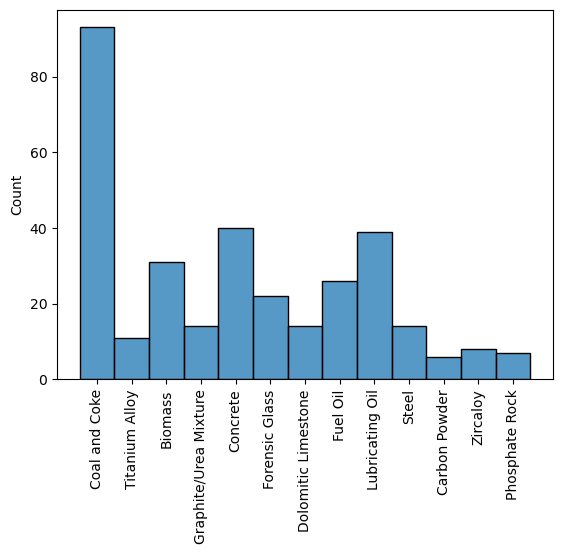

In [8]:
ax = sns.histplot(x=data_bunch['target'])
ax.tick_params(axis='x', rotation=90)

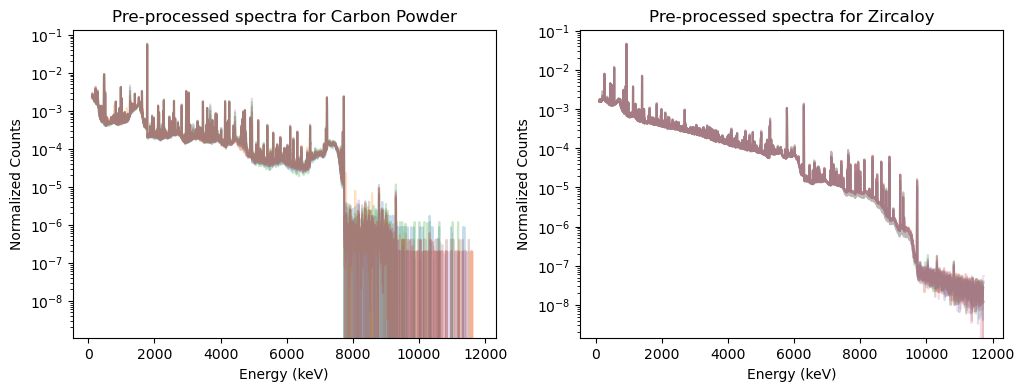

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

def plot(ax, name):
    mask = data_bunch['target'] == name
    for spectra in data_bunch['data'][mask]:
        ax.plot(data_bunch['feature_names'], spectra, alpha=0.25)
    ax.set_yscale('log')
    ax.set_xlabel('Energy (keV)')
    ax.set_ylabel('Normalized Counts')
    ax.set_title(f'Pre-processed spectra for {name}')
    
plot(axes[0], 'Carbon Powder')
plot(axes[1], 'Zircaloy')

In [10]:
# Let's select only the classes with at least 10 samples to do modeling
X, y = data_bunch['data'], data_bunch['target']

min_obs = 10
cats, counts = np.unique(y, return_counts=True)
training_cats = dict([ca,co] for ca,co in zip(cats, counts) if co > min_obs)

mask = np.array([True if c in training_cats else False for c in y])

X_challenge = X[~mask]
y_challenge = y[~mask]

X = X[mask]
y = y[mask]

In [11]:
# Select a stratified 80:20 split for train:test
X_tr, X_te, y_tr, y_te = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# Will do 5-fold CV to optimize hyperparameters
k_fold = 5

# Logistic Regression

First, let's build a discriminative model to learn about the differences between the classes.

In [12]:
def plot_hard_decision_boundaries_2d(X_proj, y, clf, resolution=0.02, bounds=5):
    from sklearn.preprocessing import LabelEncoder
    enc = LabelEncoder()
    enc.fit(y)
    
    x1_min, x1_max = X_proj[:,0].min()-bounds*resolution, X_proj[:,0].max()+bounds*resolution
    x2_min, x2_max = X_proj[:,1].min()-bounds*resolution, X_proj[:,1].max()+bounds*resolution
    
    xg1, xg2 = np.meshgrid(
        np.arange(x1_min, x1_max, resolution),
        np.arange(x2_min, x2_max, resolution),
    )
    
    Z = enc.transform(clf.predict(np.array([xg1.ravel(), xg2.ravel()]).T))
    Z = Z.reshape(xg1.shape)
    plt.contourf(xg1, xg2, Z, alpha=0.4, levels=len(np.unique(y))+1, cmap='gray')
    
    cmap = plt.cm.tab20
    for i,class_ in enumerate(np.unique(y)):
        mask = y == class_
        color = cmap(i)
        plt.plot(X_proj[mask,0], X_proj[mask,1], '.', label=class_, color=color)

Simple Model
---

In [42]:
# Build a pipeline
steps = [
    ('variance_threshold', VarianceThreshold(
        threshold=1.0
    )),
    ('model', LogisticRegression(
        random_state=42,
        solver='lbfgs', 
        max_iter=10000,
        multi_class='multinomial',
        class_weight='balanced', # Class balancing achieved in-situ rather than with SMOTE, for example.
        fit_intercept=True
    ))
]
    
# Set up parameters to search over
param_grid = {
    'variance_threshold__threshold':[1.0e-12, 1.0e-10, 1.0e-8, 1.0e-6, 1.0e-4],
    'model__penalty':[None, 'l2'],
    'model__C':np.logspace(-3, 2, 6),
}

pipeline = imblearn.pipeline.Pipeline(steps=steps)
    
# Optimize hyperparameters
gs = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=sklearn.model_selection.StratifiedKFold(
        n_splits=k_fold, 
        shuffle=True, 
        random_state=0,
    ),
    error_score=0,
    refit=True # Re-fit the model on the entire dataset
)
    
gs.fit(X_tr, y_tr)

In [14]:
gs.best_params_ 

{'model__C': 0.001,
 'model__penalty': None,
 'variance_threshold__threshold': 1e-08}

In [15]:
# Excellent performance, but why?
print(gs.score(X_tr, y_tr), gs.score(X_te, y_te))

1.0 1.0


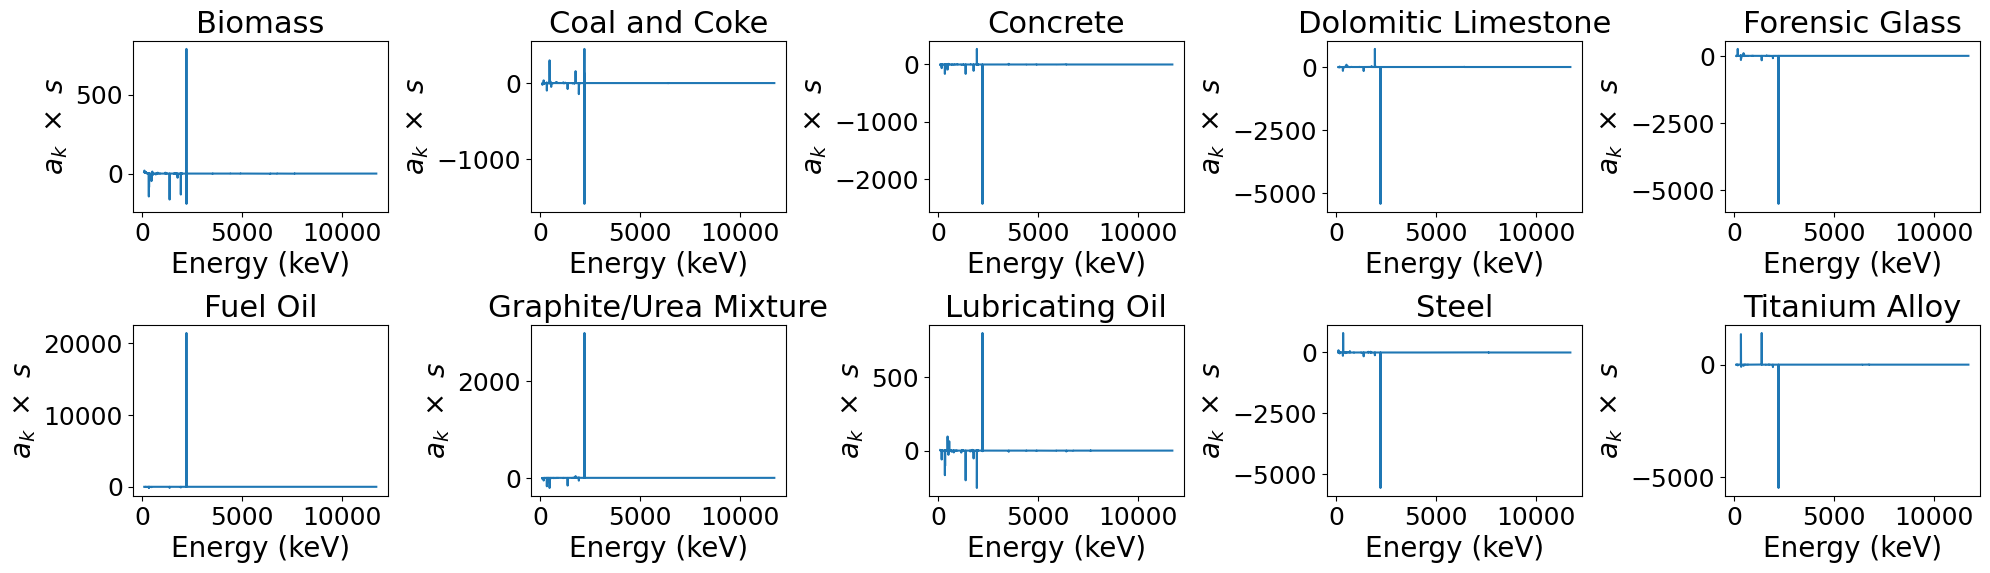

In [16]:
# Clearly a subset of peaks are very important for distinguishing one class from another, mostly around 2224 keV (the
# hydrogen peak).  This suggests the presence or absence of H is an important feature which separates these materials
# from each other.

# See the documentation for interpretation of the sign of these values:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
# Positive values correspond to "True" (belongs to class).

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20,8))
max_peaks = {}
for i, ax in enumerate(axes.flatten()):
    if i < len(gs.best_estimator_.named_steps['model'].classes_):
        # Non-dimensionalize coefficients
        coefs = gs.best_estimator_.named_steps['model'].coef_[i] * gs.best_estimator_.named_steps['variance_threshold'].transform(np.std(X_tr, axis=0).reshape(1,-1))
        ax.plot(
            data_bunch['feature_names'],
            gs.best_estimator_.named_steps['variance_threshold'].inverse_transform(coefs.reshape(1,-1))[0]
        )
        ax.set_xlabel('Energy (keV)', fontsize=20)
        ax.set_ylabel(r'$a_k~\times~s$', fontsize=20)
        max_peaks[gs.best_estimator_.named_steps['model'].classes_[i]] = np.argsort(np.abs(gs.best_estimator_.named_steps['variance_threshold'].inverse_transform(coefs.reshape(1,-1))[0]))[::-1]
        ax.set_title('{}'.format(gs.best_estimator_.named_steps['model'].classes_[i]), fontsize=22)
        ax.tick_params(axis='both', which='major', labelsize=18)
    else:
        ax.set_visible(False)
plt.tight_layout()

Reduce Dimensionality
---

For comparison, let's train a pipeline that uses PCA to see if we get a similar explanation.

In [43]:
# Build a pipeline
steps = [
    ('variance_threshold', VarianceThreshold(
        threshold=1.0
    )),
    ('scaling', CorrectedScaler(
                with_mean=True, # Always center and scale if bothering to use
                with_std=True,
                pareto=False,
                biased=False
    )),
    ('dim_red', PCA( # This automatically centers, but does not scale the data
        n_components=2, # For this example, we will force this to be 2 for easy visualization
    )),
    ('model', LogisticRegression(
        random_state=42,
        solver='lbfgs', 
        max_iter=10000,
        multi_class='multinomial',
        class_weight='balanced', # Class balancing achieved in-situ rather than with SMOTE, for example.
        fit_intercept=True
    ))
]
    
# Set up parameters to search over
param_grid = {
    'variance_threshold__threshold':[1.0e-12, 1.0e-10, 1.0e-8, 1.0e-6, 1.0e-4],
    'scaling__pareto':[True, False],
    'model__penalty':[None, 'l2'],
    'model__C':np.logspace(-3, 2, 6),
}

pipeline = imblearn.pipeline.Pipeline(steps=steps)
    
# Optimize hyperparameters
gs = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=sklearn.model_selection.StratifiedKFold(
        n_splits=k_fold, 
        shuffle=True, 
        random_state=0,
    ),
    error_score=0,
    refit=True # Re-fit the model on the entire dataset
)
    
gs.fit(X_tr, y_tr)

In [18]:
gs.best_params_

{'model__C': 0.001,
 'model__penalty': None,
 'scaling__pareto': True,
 'variance_threshold__threshold': 1e-08}

In [19]:
# Still a pretty good model even in only 2D.
print(gs.score(X_tr, y_tr), gs.score(X_te, y_te))

0.9506172839506173 0.9672131147540983


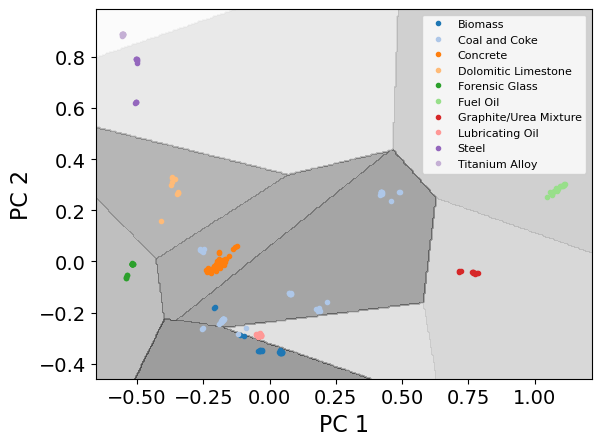

In [20]:
# In the PCA score space we clearly see most of the materials separate well along the two PCs.

preprocessing = imblearn.pipeline.Pipeline(steps=gs.best_estimator_.steps[:-1])
X_proj = preprocessing.transform(X_tr)

plot_hard_decision_boundaries_2d(
    preprocessing.transform(X_tr), 
    y_tr, 
    gs.best_estimator_.named_steps['model'],
    resolution=0.005,
    bounds=20
)

plt.legend(loc='best', fontsize=8)
plt.xlabel('PC 1', fontsize=16)
plt.ylabel('PC 2', fontsize=16)
plt.gca().tick_params(axis='both', which='major', labelsize=14)

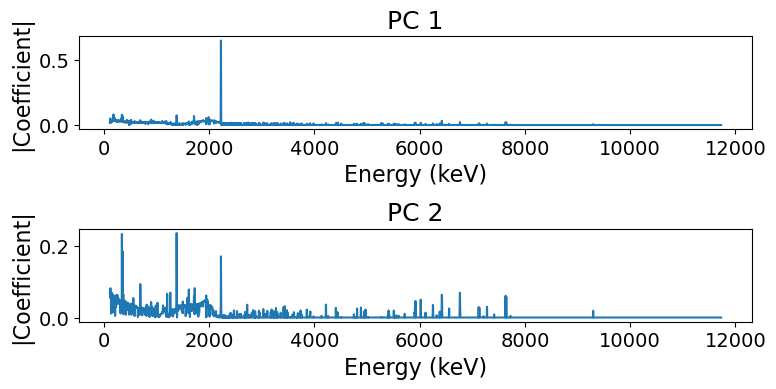

In [21]:
# Look at the loadings to understand the 2 PCs.  Again, we see PC1 is basically the hydrogen content (peak at 2224 keV)
# while PC2 is placing emphasis on peaks coming from Ti as well (342 and 1382 keV).  Obviously, this is because there 
# are materials with Ti present in the training set.  If we have a different set of materials, then this might not
# be deemed relevant.

def plot_importance(gs, aligned_centers, dim, return_max=1, ax=None):
    loadings = np.abs(gs.best_estimator_.named_steps['dim_red'].components_[dim])
    peaks = gs.best_estimator_.named_steps['variance_threshold'].inverse_transform(loadings.reshape(1,-1))[0]
    ax.plot(
        aligned_centers,
        peaks,
    )
    ax.set_xlabel('Energy (keV)', fontsize=16)
    ax.set_ylabel('|Coefficient|', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    return peaks[np.argsort(peaks)[::-1]][:return_max], aligned_centers[np.argsort(peaks)[::-1]][:return_max]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8,4))
axes[0].set_title('PC 1', fontsize=18)
axes[1].set_title('PC 2', fontsize=18)

_ = plot_importance(gs, np.array(data_bunch['feature_names']), dim=0, return_max=1, ax=axes[0])
_ = plot_importance(gs, np.array(data_bunch['feature_names']), dim=1, return_max=1, ax=axes[1])
plt.tight_layout()

# Soft PLS-DA Model

In [44]:
# Build a pipeline
steps = [
    ('variance_threshold', VarianceThreshold(
        threshold=1.0
    )),
    ('class_balancer', ScaledSMOTEENN(
        random_state=42,
        k_enn=3,
        k_smote=3,
        kind_sel_enn='all'
    )),
    ('dim_red', PCA( # This automatically centers, but does not scale the data
        n_components=1,
        svd_solver='arpack',
        tol=1.0e-6
    )),
    ('model', PLSDA(
            gamma=0.01, 
           not_assigned='UNKNOWN', 
           style='soft', 
           score_metric='TEFF'
    ))
]
    
# Set up parameters to search over
param_grid = {
    'variance_threshold__threshold':[1.0e-8, 1.0e-6, 1.0e-4],
    'class_balancer__k_enn':[3, 5], 
    'class_balancer__k_smote':[3, 5], 
    'dim_red__n_components': [2, 3, 4, 5, 10, 20],
    'model__scale_x':[True, False],
    'model__n_components':[1, 2, 3, 4, 5, 10, 20, 50],
    'model__alpha':[0.05],
}

pipeline = imblearn.pipeline.Pipeline(steps=steps)
    
# Optimize hyperparameters
gs = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=sklearn.model_selection.StratifiedKFold(
        n_splits=k_fold, 
        shuffle=True, 
        random_state=0,
    ),
    error_score=0,
    refit=True # Re-fit the model on the entire dataset
)
    
gs.fit(X_tr, y_tr)

In [23]:
gs.best_params_ 

{'class_balancer__k_enn': 3,
 'class_balancer__k_smote': 3,
 'dim_red__n_components': 10,
 'model__alpha': 0.05,
 'model__n_components': 2,
 'model__scale_x': True,
 'variance_threshold__threshold': 1e-08}

In [24]:
gs.score(X_tr, y_tr) # TEFF

0.9887530087731263

In [25]:
gs.score(X_te, y_te) # TEFF

0.9733220680684054

In [26]:
fom = gs.best_estimator_.named_steps['model'].figures_of_merit(
    gs.predict(X_te),
    y_te
)

In [27]:
fom['CM']

,Biomass,Coal and Coke,Concrete,Dolomitic Limestone,Forensic Glass,Fuel Oil,Graphite/Urea Mixture,Lubricating Oil,Steel,Titanium Alloy,UNKNOWN
Biomass,6,0,0,0,0,0,0,0,0,0,0
Coal and Coke,0,18,0,0,0,0,0,0,0,0,1
Concrete,0,0,8,0,0,0,0,0,0,0,0
Dolomitic Limestone,0,0,0,3,0,0,0,0,0,0,0
Forensic Glass,0,0,0,0,4,0,0,0,0,0,0
Fuel Oil,0,0,0,0,0,5,0,0,0,0,0
Graphite/Urea Mixture,0,0,0,0,0,0,2,0,0,0,1
Lubricating Oil,0,2,0,0,0,0,0,8,0,0,0
Steel,0,0,0,0,0,0,0,0,3,0,0
Titanium Alloy,0,0,0,0,0,0,0,0,0,1,1


In [28]:
perf = pd.concat([fom['CSPS'], fom['CSNS'], fom['CEFF']], axis=1)
perf.columns = ['Test CSPS', 'Test CSNS', 'Test CEFF']
perf['Training Counts'] = [dict(zip(*np.unique(y_tr, return_counts=True)))[i] for i in perf.index]

In [29]:
perf.sort_values(by='Training Counts', ascending=False)

,Test CSPS,Test CSNS,Test CEFF,Training Counts
Coal and Coke,0.952381,0.947368,0.949871,74
Concrete,1.000000,1.000000,1.000000,32
Lubricating Oil,1.000000,1.000000,1.000000,31
Biomass,1.000000,1.000000,1.000000,25
Fuel Oil,1.000000,1.000000,1.000000,21
Forensic Glass,1.000000,1.000000,1.000000,18
Dolomitic Limestone,1.000000,1.000000,1.000000,11
Graphite/Urea Mixture,1.000000,0.666667,0.816497,11
Steel,1.000000,1.000000,1.000000,11
Titanium Alloy,1.000000,0.500000,0.707107,9


# SIMCA Models

In [30]:
# These performance metrics do not change, even when lower thresholds are allowed!
def summarize(simca_models, X, y):
    """Extract hyperparameters and performance metrics from models."""
    simca_metrics = {}
    display = []
    for target_class in simca_models.keys():
        preprocess_pipe = imblearn.pipeline.Pipeline(steps=simca_models[target_class].best_estimator_.steps[:-2]) 
        # ScaledSMOTEENN should pass through anyway

        simca_metrics[target_class] = simca_models[target_class].best_estimator_.named_steps['model'].metrics(
            preprocess_pipe.transform(X), 
            y
        )
        
        compliant = False
        if 'model__alpha' in simca_models[target_class].best_params_:
            compliant = True

        display.append([
            target_class, 
            simca_metrics[target_class]['TSNS'], 
            simca_metrics[target_class]['TSPS'], 
            simca_metrics[target_class]['TEFF'], 
            simca_models[target_class].best_params_['model__n_components'], 
            simca_models[target_class].best_params_['variance_threshold__threshold'], 
            simca_models[target_class].best_params_['model__alpha'] if compliant else simca_models[target_class].best_estimator_.named_steps['model'].get_params()['alpha']
        ])
    
    return pd.DataFrame(
        data=display, 
        columns=['Target class', 'Test TSNS', 'Test TSPS', 'Test TEFF', 'n_components', 'threshold', 'alpha'] 
    )

def plot_simca(simca_models, X, y):
    """Make distance plots for all classes."""
    def plot_(simca_models, target_class, X, y, ax=None, no_legend=True):
        preprocess_pipe = imblearn.pipeline.Pipeline(
            steps=simca_models[target_class].best_estimator_.steps[:-2]) # ScaledSMOTEENN should pass through anyway

        ax = simca_models[target_class].best_estimator_.named_steps['model'].model.visualize(
            preprocess_pipe.transform(X), 
            y,
            ax=ax
        )

        ax.set_title('DD-SIMCA Model for \n{}'.format(target_class))
        if no_legend:
            ax.get_legend().remove()
    
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15,10))
    for ax, target_class in zip(axes.flatten(), simca_models.keys()):
        plot_(simca_models, target_class, X, y, ax=ax)
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.set_title(ax.get_title(), fontsize=18)
        ax.set_xlabel('ln'+'(1 + h/h'+r'$_0$'+')', fontsize=16)
        ax.set_ylabel('ln'+'(1 + q/q'+r'$_0$'+')', fontsize=16)

    axes.flatten()[-1].set_visible(False)
    axes.flatten()[-2].set_visible(False)
    plt.tight_layout()

Compliant Models
---

In [31]:
compliant_simca_models = {}
for i, target_class in tqdm.tqdm(enumerate(sorted(np.unique(y_tr)))):
    
    # Build a pipeline
    steps = [
        ('variance_threshold', VarianceThreshold(
            threshold=1.0
        )),
        ('class_balancer', ScaledSMOTEENN(
            random_state=42,
            k_enn=3,
            k_smote=3,
            kind_sel_enn='all'
        )),
        ('model', SIMCA_Authenticator(
            target_class=target_class, 
            style="dd-simca", 
            use="compliant",
            robust=None,
            sft=False)
        )
    ]
    
    # Set up parameters to search over
    param_grid = {
        'variance_threshold__threshold':[1.0e-8, 1.0e-6, 1.0e-4],
        'class_balancer__k_enn':[3, 5], 
        'class_balancer__k_smote':[3, 5], 
        'model__scale_x':[True, False],
        'model__n_components':np.arange(1, 6+1),
        'model__alpha':[0.01, 0.05],
    }

    pipeline = imblearn.pipeline.Pipeline(steps=steps)
    
    # Optimize hyperparameters
    gs = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        n_jobs=-1,
        cv=sklearn.model_selection.StratifiedKFold(
            n_splits=k_fold, 
            shuffle=True, 
            random_state=0,
        ),
        error_score=0,
        refit=True # Re-fit the model on the entire dataset
    )
    
    gs.fit(X_tr, y_tr)
    
    compliant_simca_models[target_class] = gs

10it [01:04,  6.46s/it]


In [32]:
# Examine the performance of the best models / pipelines.  This is part of Table 2 in Mahynski et al.
pd.set_option("display.precision", 3)
summarize(compliant_simca_models, X_te, y_te)

,Target class,Test TSNS,Test TSPS,Test TEFF,n_components,threshold,alpha
0,Biomass,1.000,1.0,1.000,2,1.000e-04,0.01
1,Coal and Coke,1.000,1.0,1.000,3,1.000e-06,0.01
2,Concrete,0.875,1.0,0.935,1,1.000e-08,0.01
3,Dolomitic Limestone,1.000,1.0,1.000,1,1.000e-06,0.01
4,Forensic Glass,1.000,1.0,1.000,1,1.000e-04,0.01
5,Fuel Oil,1.000,1.0,1.000,2,1.000e-08,0.01
6,Graphite/Urea Mixture,0.667,1.0,0.816,1,1.000e-04,0.01
7,Lubricating Oil,1.000,1.0,1.000,1,1.000e-08,0.01
8,Steel,1.000,1.0,1.000,1,1.000e-08,0.01
9,Titanium Alloy,0.500,1.0,0.707,1,1.000e-04,0.01


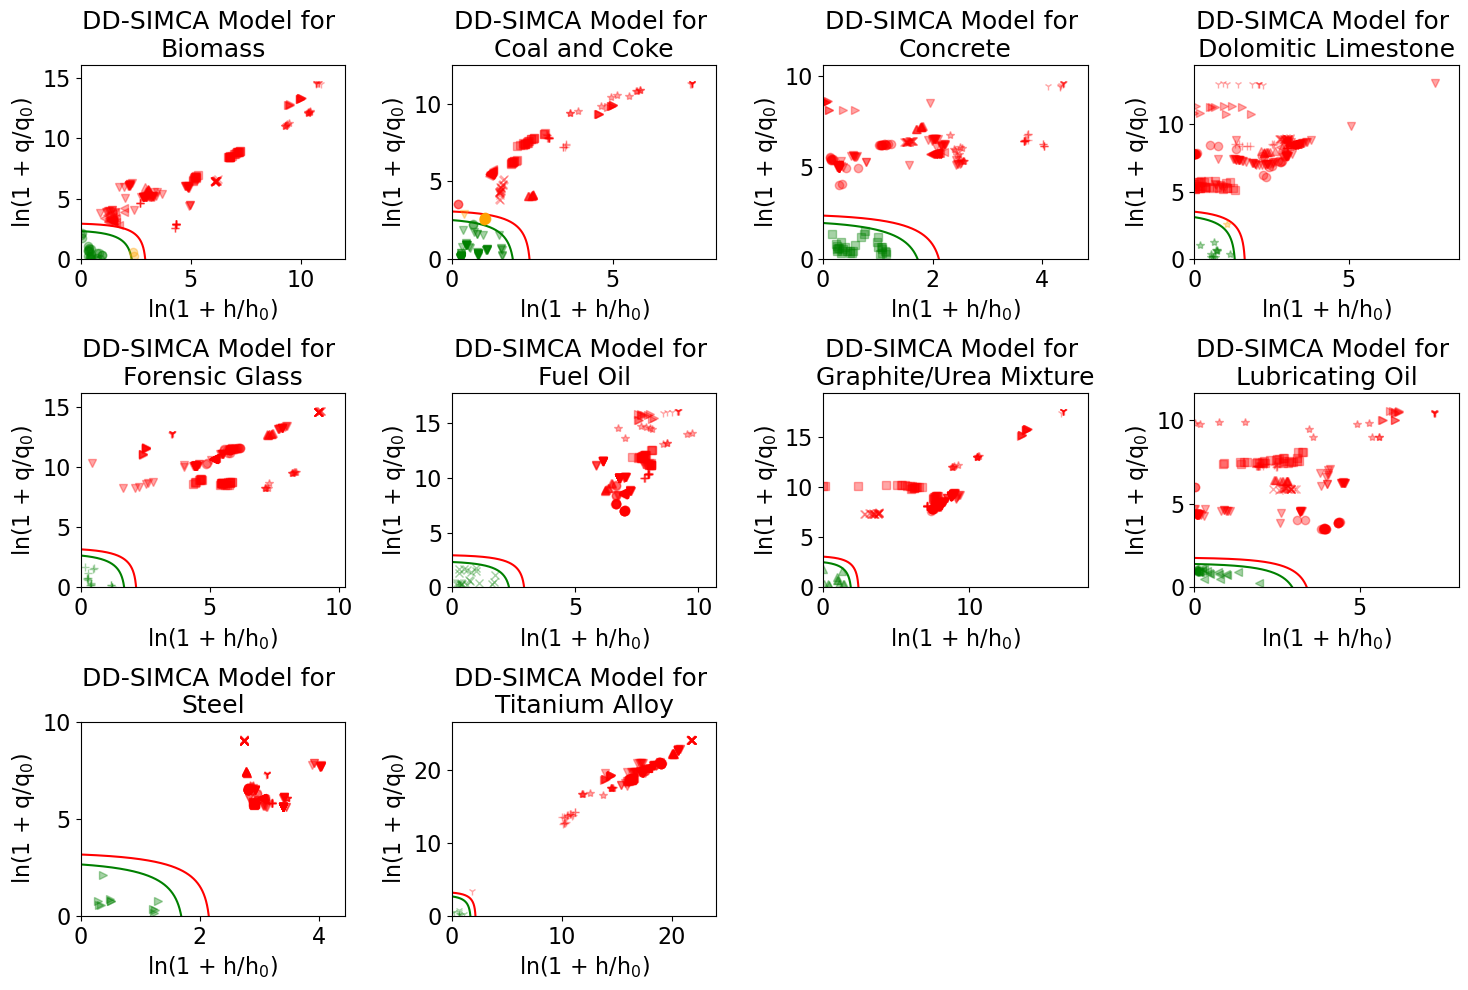

In [33]:
plot_simca(compliant_simca_models, X_tr, y_tr)

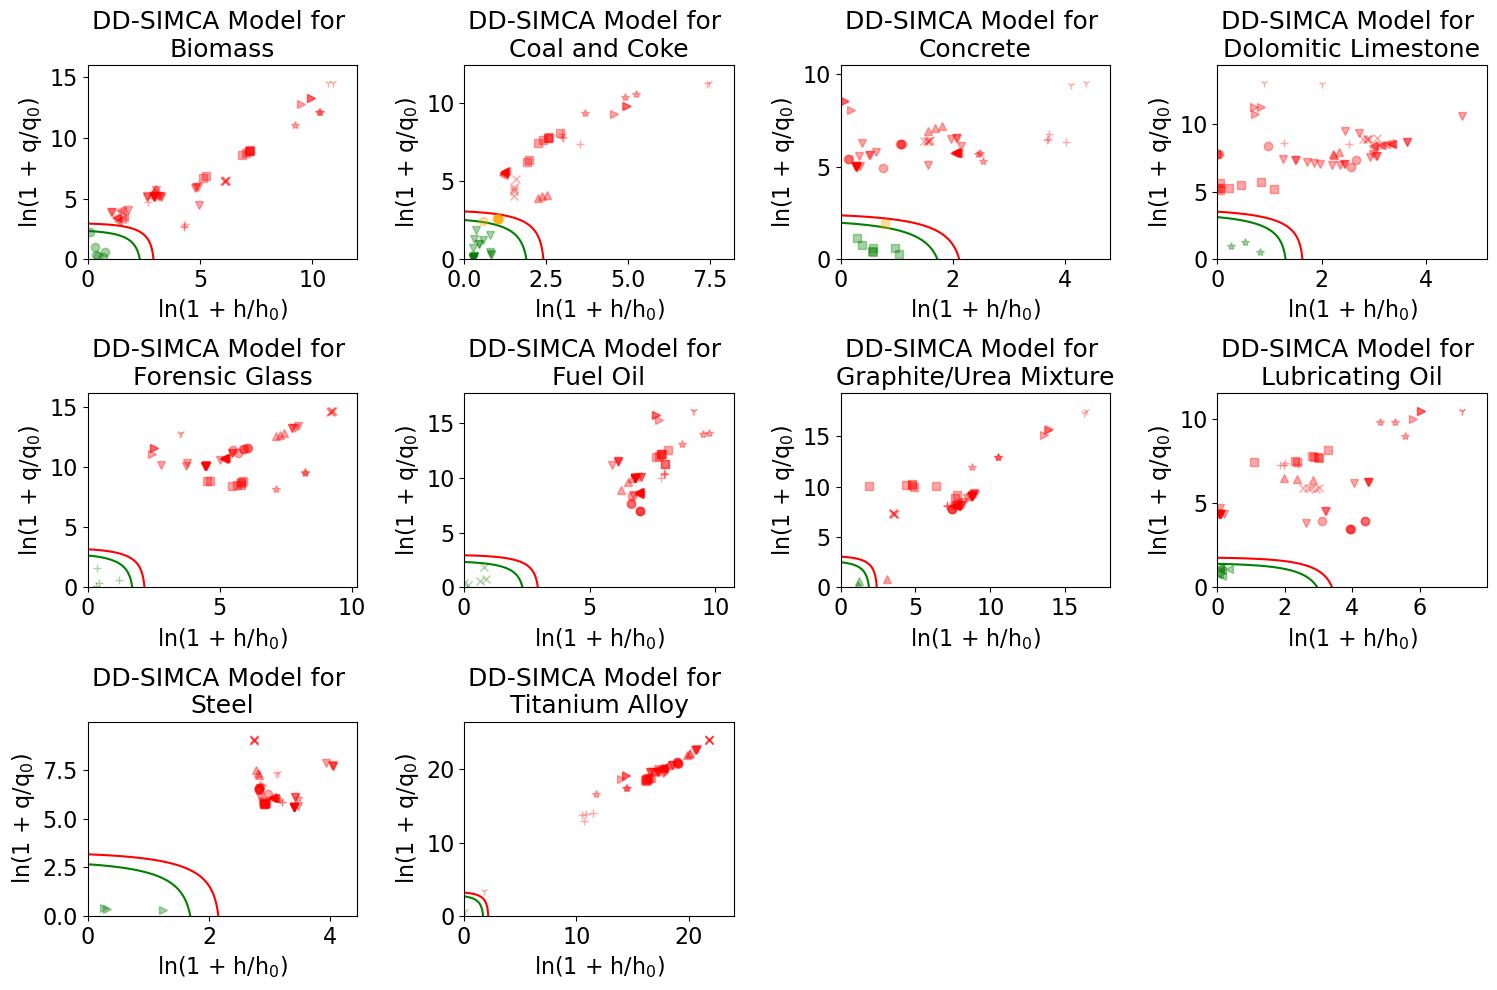

In [34]:
plot_simca(compliant_simca_models, X_te, y_te)

Rigorous Models
---

In [35]:
rigorous_simca_models = {}
for i, target_class in tqdm.tqdm(enumerate(sorted(np.unique(y_tr)))):
    
    # Build a pipeline
    steps = [
        ('variance_threshold', VarianceThreshold(
            threshold=1.0
        )),
        ('class_balancer', ScaledSMOTEENN(
            random_state=42,
            k_enn=3,
            k_smote=3,
            kind_sel_enn='all'
        )),
        ('model', SIMCA_Authenticator(
            target_class=target_class, 
            style="dd-simca", 
            use="rigorous",
            alpha=0.01, # This was universally selected by compliant models so keep this value for fair comparison
            robust=None,
            sft=False)
        )
    ]
    
    # Set up parameters to search over
    param_grid = {
        'variance_threshold__threshold':[1.0e-8, 1.0e-6],
        'class_balancer__k_enn':[3, 5], 
        'class_balancer__k_smote':[3, 5], 
        'model__scale_x':[True, False],
        'model__n_components':np.arange(1, 6+1),
    }

    pipeline = imblearn.pipeline.Pipeline(steps=steps)
    
    # Optimize hyperparameters
    gs = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        n_jobs=-1,
        cv=sklearn.model_selection.StratifiedKFold(
            n_splits=k_fold, 
            shuffle=True, 
            random_state=0,
        ),
        error_score=0,
        refit=True # Re-fit the model on the entire dataset
    )
    
    gs.fit(X_tr, y_tr)
    
    rigorous_simca_models[target_class] = gs

10it [00:28,  2.85s/it]


In [36]:
# Examine the performance of the best models / pipelines.  This is part of Table 2 in Mahynski et al.
pd.set_option("display.precision", 3)
summarize(rigorous_simca_models, X_te, y_te)

,Target class,Test TSNS,Test TSPS,Test TEFF,n_components,threshold,alpha
0,Biomass,1.000,0.982,0.991,1,1.000e-06,0.01
1,Coal and Coke,1.000,0.619,0.787,1,1.000e-08,0.01
2,Concrete,0.875,1.000,0.935,1,1.000e-08,0.01
3,Dolomitic Limestone,1.000,1.000,1.000,1,1.000e-06,0.01
4,Forensic Glass,1.000,1.000,1.000,1,1.000e-08,0.01
5,Fuel Oil,1.000,1.000,1.000,2,1.000e-08,0.01
6,Graphite/Urea Mixture,0.667,1.000,0.816,1,1.000e-08,0.01
7,Lubricating Oil,1.000,1.000,1.000,1,1.000e-08,0.01
8,Steel,1.000,1.000,1.000,1,1.000e-08,0.01
9,Titanium Alloy,0.500,1.000,0.707,1,1.000e-08,0.01


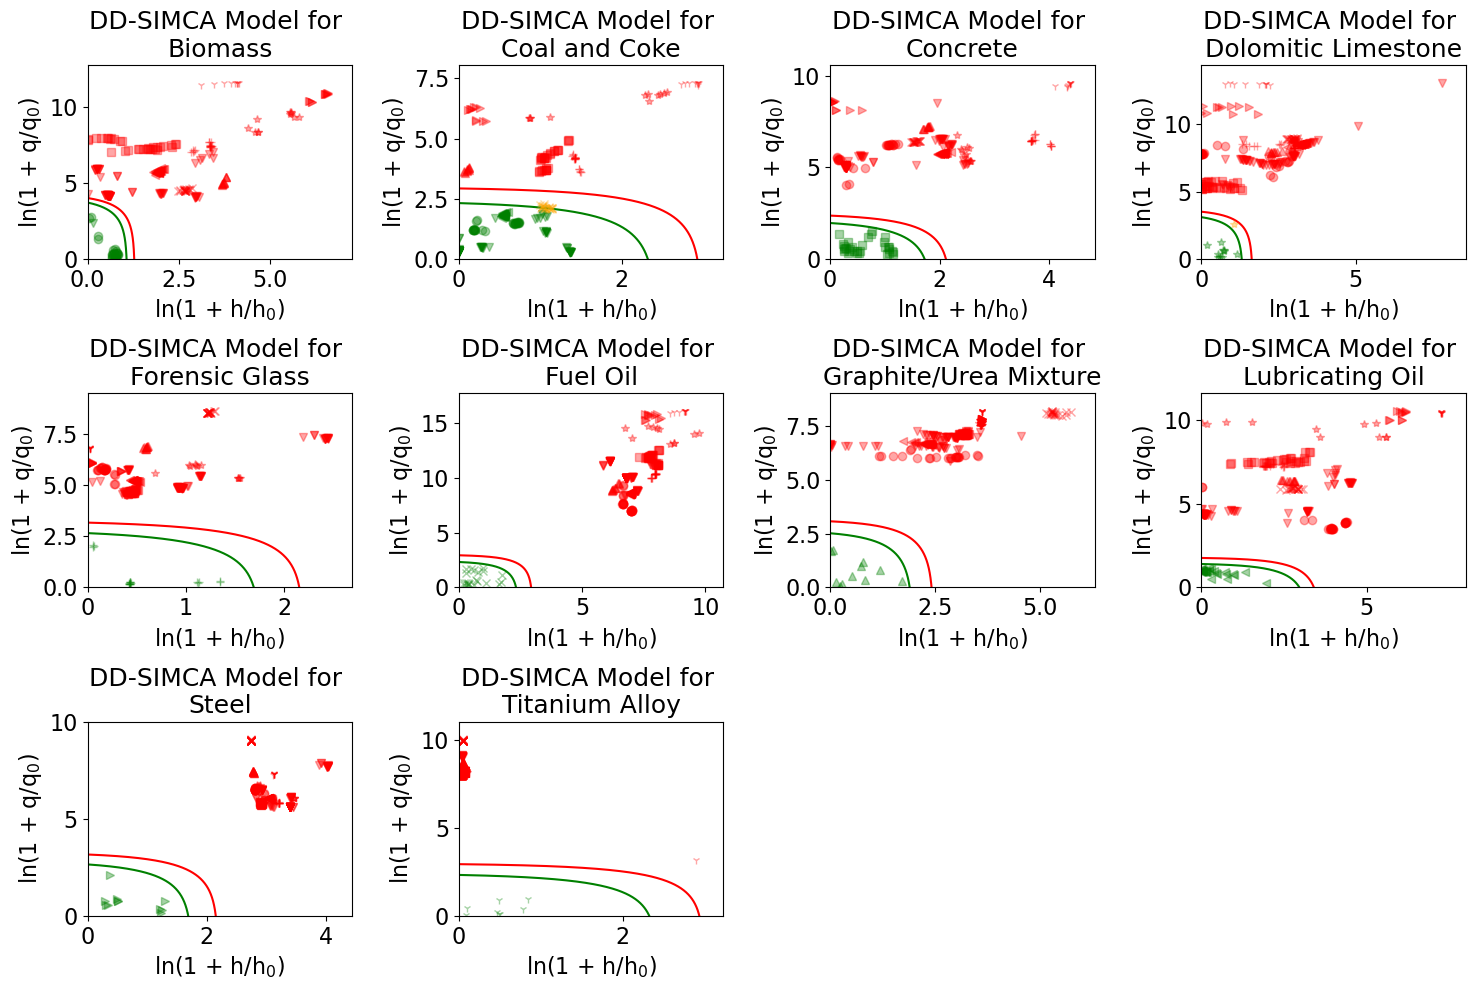

In [37]:
plot_simca(rigorous_simca_models, X_tr, y_tr)

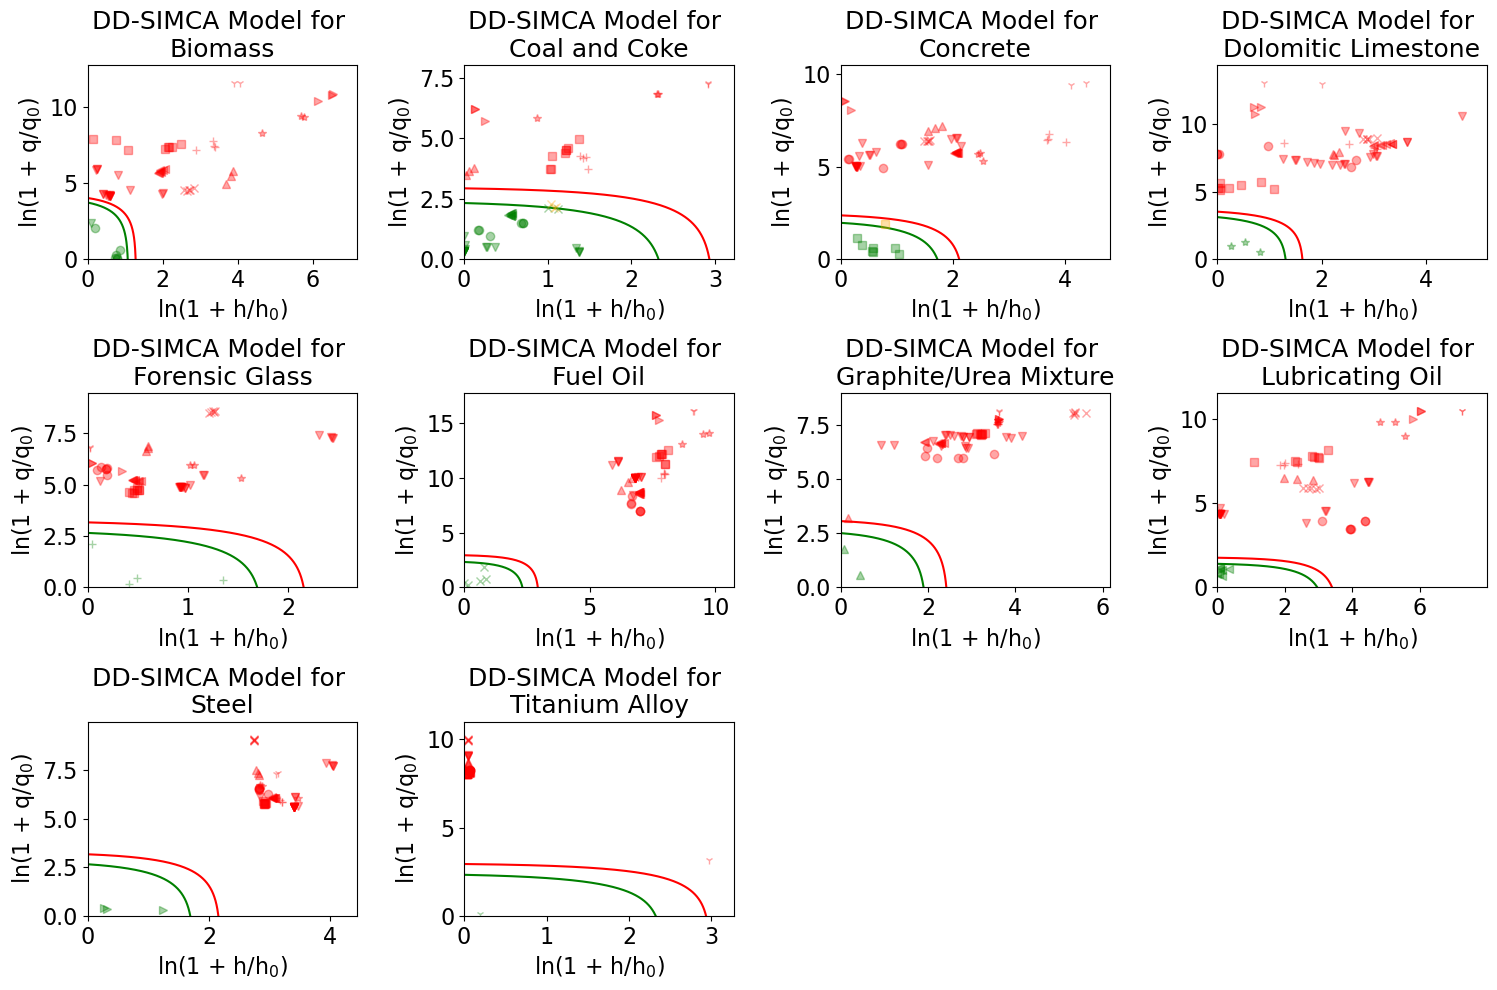

In [38]:
plot_simca(rigorous_simca_models, X_te, y_te)

Testing against unknowns
---

In [39]:
np.unique(y_challenge)

array(['Carbon Powder', 'Phosphate Rock', 'Zircaloy'], dtype=object)

In [40]:
# Perfect performance - all models rejected these 3 challenge classes as members.
summarize(compliant_simca_models, X_challenge, y_challenge)

,Target class,Test TSNS,Test TSPS,Test TEFF,n_components,threshold,alpha
0,Biomass,NaN,1.0,1.0,2,1.000e-04,0.01
1,Coal and Coke,NaN,1.0,1.0,3,1.000e-06,0.01
2,Concrete,NaN,1.0,1.0,1,1.000e-08,0.01
3,Dolomitic Limestone,NaN,1.0,1.0,1,1.000e-06,0.01
4,Forensic Glass,NaN,1.0,1.0,1,1.000e-04,0.01
5,Fuel Oil,NaN,1.0,1.0,2,1.000e-08,0.01
6,Graphite/Urea Mixture,NaN,1.0,1.0,1,1.000e-04,0.01
7,Lubricating Oil,NaN,1.0,1.0,1,1.000e-08,0.01
8,Steel,NaN,1.0,1.0,1,1.000e-08,0.01
9,Titanium Alloy,NaN,1.0,1.0,1,1.000e-04,0.01


In [41]:
# Perfect performance - all models rejected these 3 challenge classes as members.
summarize(rigorous_simca_models, X_challenge, y_challenge)

,Target class,Test TSNS,Test TSPS,Test TEFF,n_components,threshold,alpha
0,Biomass,NaN,1.0,1.0,1,1.000e-06,0.01
1,Coal and Coke,NaN,1.0,1.0,1,1.000e-08,0.01
2,Concrete,NaN,1.0,1.0,1,1.000e-08,0.01
3,Dolomitic Limestone,NaN,1.0,1.0,1,1.000e-06,0.01
4,Forensic Glass,NaN,1.0,1.0,1,1.000e-08,0.01
5,Fuel Oil,NaN,1.0,1.0,2,1.000e-08,0.01
6,Graphite/Urea Mixture,NaN,1.0,1.0,1,1.000e-08,0.01
7,Lubricating Oil,NaN,1.0,1.0,1,1.000e-08,0.01
8,Steel,NaN,1.0,1.0,1,1.000e-08,0.01
9,Titanium Alloy,NaN,1.0,1.0,1,1.000e-08,0.01
